### Image Classification with MNIST dataset and Lightning and MLFlow

In this NB the FC NN has been replaced with a **CNN**.

There is an improvement: accuracy goes to **0.99** !!

* integration with MLFlow
* added checkpoint to save best based on val_loss

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch

from IPython.core.display import display

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.loggers import MLFlowLogger

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

# from here we get MNIST dataset
from torchvision.datasets import MNIST

# for experiment tracking
import mlflow

sn.set()

%matplotlib inline

In [20]:
# setting for MLFlow
from config import (MLFLOW_TRACKING_URI, MLFLOW_TRACKING_USERNAME,
                    MLFLOW_TRACKING_PASSWORD, MLFLOW_S3_ENDPOINT_URL,
                    AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

os.environ['MLFLOW_TRACKING_URI'] = MLFLOW_TRACKING_URI
os.environ['MLFLOW_TRACKING_USERNAME'] = MLFLOW_TRACKING_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = MLFLOW_TRACKING_PASSWORD
# for storing on OSS
os.environ['MLFLOW_S3_ENDPOINT_URL'] = MLFLOW_S3_ENDPOINT_URL
os.environ['AWS_ACCESS_KEY_ID'] = AWS_ACCESS_KEY_ID
os.environ['AWS_SECRET_ACCESS_KEY'] = AWS_SECRET_ACCESS_KEY

In [21]:
# where we're storing the downloaded datase
PATH_DATASETS = "."

BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [22]:
class LitMNISTCNN(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # dataset specific attributes
        self.num_classes = 10
        # shape of input images in MNIST
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                # normalization is clarified here
                # https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model: a simple CNN
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Flatten(),
            nn.Linear(3*3*64, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, self.num_classes),
        )

        self.val_accuracy = Accuracy()
        self.test_accuracy = Accuracy()

    def forward(self, x):
        # the model outputs logits not probabilities
        # this is better for numerical stability
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    # dataset and dataloaders

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE, num_workers=6)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE, num_workers=6)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE, num_workers=6)

In [27]:
EXP_NAME = "LT004"
RUN_NAME = "run001"

mlf_logger = MLFlowLogger(experiment_name=EXP_NAME, run_name = RUN_NAME, 
                          tracking_uri=MLFLOW_TRACKING_URI)

# how to log HP
params = {"lr": 2e-4}
mlf_logger.log_hyperparams(params)

checkpoint_callback = ModelCheckpoint(dirpath="checkpoint_mnist", save_top_k=2, monitor="val_loss",
                                     mode="min",
                                     filename="mnist-{epoch:02d}-{val_loss:.2f}")

Experiment with name LT004 not found. Creating it.


In [28]:
model = LitMNISTCNN()

trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    max_epochs=20,
    callbacks=[TQDMProgressBar(refresh_rate=20), checkpoint_callback],
    logger=[CSVLogger(save_dir="logs/"), mlf_logger]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


#### Fit

In [29]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | model         | Sequential | 228 K 
1 | val_accuracy  | Accuracy   | 0     
2 | test_accuracy | Accuracy   | 0     
---------------------------------------------
228 K     Trainable params
0         Non-trainable params
228 K     Total params
0.912     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [30]:
trainer.test()

/home/datascience/conda/computervision_p37_gpu_v1/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
Restoring states from the checkpoint path at /home/datascience/pytorch-on-oci/ch-mlflow/checkpoint_mnist/mnist-epoch=19-val_loss=0.03-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/datascience/pytorch-on-oci/ch-mlflow/checkpoint_mnist/mnist-epoch=19-val_loss=0.03-v2.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9939000010490417
        test_loss          0.018033888190984726
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.018033888190984726, 'test_acc': 0.9939000010490417}]

#### Plot the metrics' history

/home/datascience/conda/computervision_p37_gpu_v1/lib/python3.7/site-packages/ipykernel_launcher.py:2: LightningDeprecationWarning: Using `trainer.logger` when multiple loggers are configured. This behavior will change in v1.8 when `LoggerCollection` is removed, and `trainer.logger` will return the first logger available.
  


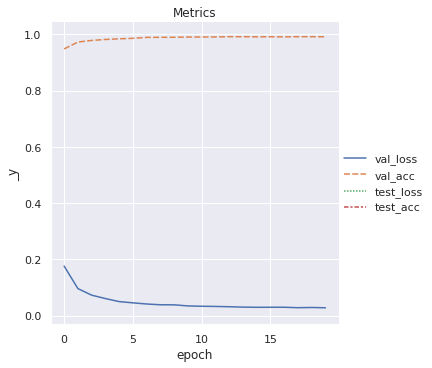

In [31]:
# modified adding [0] since we have now two loggers
metrics = pd.read_csv(f"{trainer.logger[0].log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)

# if you want also in tabular format
# display(metrics.dropna(axis=1, how="all").tail(10))
sn.relplot(data=metrics, kind="line").set(title='Metrics');
plt.grid(True)
plt.show()

#### Reload from checkpoint and test the model

In [11]:
model = LitMNISTCNN.load_from_checkpoint("./checkpoint_mnist/best.ckpt")

In [12]:
model

LitMNISTCNN(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=576, out_features=256, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.1, inplace=False)
    (14): Linear(in_features=256, out_features=10, bias=True)
  )
  (val_accuracy): Accuracy()
  (test_accuracy): Accuracy()
)

In [13]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9941999912261963
        test_loss          0.018548643216490746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.018548643216490746, 'test_acc': 0.9941999912261963}]